In [197]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
DEBUG = "CIRCLES"

In [198]:
class Ball:
    def __init__(self, team, label, loc):
        self.team = team
        self.label = label
        self.loc = loc

## Threshold by color and mask

In [199]:
# order is blue, green, red
def mask_table(color_img):
    pixels = []
    for i in color_img:
        for j in i:
            pixels.append(j)
    pixels = np.array(pixels)
    bins = [0,100,150,255]
    hist, bins = np.histogramdd(pixels, bins=(bins, bins, bins))

    # find the highest histogram bin
    max_r, max_g, max_b, max_val = 0, 0, 0, 0
    for r in range(hist.shape[0]):
        for g in range(hist.shape[1]):
            for b in range(hist.shape[2]):
                if hist[r][g][b] > max_val:
                    max_val = hist[r][g][b]
                    (max_r, max_g, max_b) = r, g, b
    bins = bins[0]
    lower = np.array([bins[max_r], bins[max_g], bins[max_b]])
    upper = np.array([bins[max_r + 1], bins[max_g + 1], bins[max_b + 1]])
    # just get the pixels in the highest histogram bin
    mask = cv2.inRange(color_img, lower, upper)

    plt.imshow(mask)
    plt.title('mask before dilation')
    plt.show()
    # fill in the holes
    kernel = np.ones((7, 7),np.uint8)
    dilation = cv2.dilate(mask, kernel, iterations=10)
    # dilation is grayscale, lets convert it to have three channels
    rgb_dilation = np.uint8(np.zeros((dilation.shape[0], dilation.shape[1], 3)))
    for i in range(rgb_dilation.shape[0]):
        for j in range(rgb_dilation.shape[1]):
            rgb_dilation[i][j][:] = dilation[i][j]

    res = cv2.bitwise_and(color_img, rgb_dilation)
    res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    if DEBUG == "MASK" or DEBUG == "ALL":
        plt.imshow(res)
        plt.show()
    return res


## Hough Circles

In [200]:
def hough_circles(full_img, masked_image, output_file):
    cimg = full_img.copy()
    if len(masked_image.shape) > 2:
        gray = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY)
    else:
        gray = masked_image
    plt.imshow(gray)
    plt.title('circle input')
    plt.show()
    alt = True
    if alt:
        h_circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT_ALT, param1=100, param2=0.6, dp=1.5, minRadius=10, maxRadius=16, minDist=5)
    else:
        h_circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, param1=cv2.CV_64F, param2=40, dp=1.75, minRadius=11, maxRadius=16, minDist=5)
    if h_circles is None:
        print("no circles found")
        return []
    h_circles = np.uint16(np.around(h_circles))

    k = 0
    for i in h_circles[0,:]:
        # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
        cv2.putText(cimg, f'{k}', (i[0],i[1]), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), 1)
        k+=1

    if DEBUG == "CIRCLES" or DEBUG == "ALL":
        plt.title("Hough Circles")
        plt.imshow(cv2.cvtColor(cimg, cv2.COLOR_BGR2RGB))
        cv2.imwrite("circles.png", cimg)
    cv2.imwrite(output_file, cimg)
    
    return h_circles


## Assume we have correct circles

In [201]:
def label_balls(color_img, hough_circs, output_file):
    ## get the pixel values of all the circles
    balls = []
    num_solids = 0
    num_stripes = 0
    if len(hough_circs) == 0:
        return balls
    for circle in hough_circs[0,:]:
        rad = circle[2]
        center_x = circle[1]
        center_y = circle[0]
        # iterate over the box containing the circle
        num_colored = 0
        num_white = 0
        num_black = 0
        for i in range(2*rad):
            for j in range(2*rad):
                tmp_x = center_x - rad + i
                tmp_y = center_y - rad + j
                # check that the point is actually in the circle
                if (tmp_x - center_x)**2 + (tmp_y - center_y)**2 < rad**2:
                    pix = color[tmp_x][tmp_y]
                    white_thresh = 100
                    black_thresh = 50
                    # the white pixels
                    if pix[0] > white_thresh and pix[1] > white_thresh and pix[2] > white_thresh:
                        num_white += 1
                    # the black pixels
                    elif pix[0] < black_thresh and pix[1] < black_thresh and pix[2] < black_thresh:
                        num_black += 1
                    else:
                        num_colored += 1
        total_pixels = num_white + num_black + num_colored
        # print(num_white / total_pixels)
        if total_pixels == 0:
            continue
        if num_white / total_pixels >= 0.95:
            ball = Ball(team=None, label="cue", loc=(center_y, center_x))
        elif num_black / total_pixels >= 0.8:
            ball = Ball(team=None, label="eight", loc=(center_y, center_x))
        elif num_white / total_pixels >= 0.25:
            ball = Ball(team="stripes", label=str(num_stripes), loc=(center_y, center_x))
            num_stripes += 1
        else:
            ball = Ball(team="solids", label=str(num_solids), loc=(center_y, center_x))
            num_solids += 1
        balls.append(ball)

    labeled_balls = color_img.copy()
    for b in balls:
        if b.team == 'solids': col = (0,255,0)
        if b.team == 'stripes': col = (255,0,255)
        if b.team == None: col = (255,150,0)
        cv2.putText(labeled_balls, b.team if b.team else b.label, (b.loc[0],b.loc[1]), cv2.FONT_HERSHEY_PLAIN, 1, col, 1)
        cv2.circle(labeled_balls,(b.loc[0],b.loc[1]),2,col,2)

    if DEBUG == "LABELS" or DEBUG == "ALL":
        plt.imshow(cv2.cvtColor(labeled_balls, cv2.COLOR_BGR2RGB))
    cv2.imwrite(output_file, labeled_balls)
    return balls


In [202]:
def contours(img):
    kernelsize = (9,9)
    blurred = cv2.GaussianBlur(img,kernelsize, sigmaX=0, sigmaY=0) 
    blurred = cv2.GaussianBlur(blurred,kernelsize, sigmaX=0, sigmaY=0) 
    blurred = cv2.GaussianBlur(blurred,kernelsize, sigmaX=0, sigmaY=0) 
    blurred = cv2.GaussianBlur(blurred,kernelsize, sigmaX=0, sigmaY=0) 
    blurred = cv2.GaussianBlur(blurred,kernelsize, sigmaX=0, sigmaY=0) 
    blurred = cv2.GaussianBlur(blurred,kernelsize, sigmaX=0, sigmaY=0) 
    blurred = cv2.GaussianBlur(blurred,kernelsize, sigmaX=0, sigmaY=0) 
    blurred = cv2.GaussianBlur(blurred,kernelsize, sigmaX=0, sigmaY=0) 
    blurred = cv2.GaussianBlur(blurred,kernelsize, sigmaX=0, sigmaY=0)
    
    scharr_X = cv2.Scharr(blurred, cv2.CV_64F, 1, 0) 
    scharr_X_abs = np.uint8(np.absolute(scharr_X)) 
    scharr_Y = cv2.Scharr(blurred, cv2.CV_64F, 0, 1) 
    scharr_Y_abs = np.uint8(np.absolute(scharr_Y)) 
    scharr_XY_combined = cv2.bitwise_or(scharr_Y_abs,scharr_X_abs) 
    cv2.imwrite("edges.png", scharr_XY_combined)
    plt.imshow(scharr_XY_combined)
    plt.title('scharrXY')
    plt.show()

    scharr_XY_combined = cv2.cvtColor(scharr_XY_combined, cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(scharr_XY_combined, 150, 255, cv2.THRESH_BINARY)
    plt.imshow(thresh)
    plt.title('thresholded')
    plt.show()


    kernel = np.ones((2, 2),np.uint8)
    eroded = cv2.erode(thresh, kernel)
    # eroded = cv2.dilate(scharr_XY_combined, kernel)
    plt.imshow(eroded)
    plt.title('eroded')
    plt.show()
    # eroded = cv2.cvtColor(eroded, cv2.COLOR_RGB2GRAY)
    # plt.imshow(eroded)
    # plt.show()
    
    
    # output = cv2.connectedComponentsWithStats(eroded, 4, cv2.CV_32S)
    # print(output)
    # plt.imshow(output)
    # plt.show()
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # ret, thresh = cv2.threshold(gray, 90, 200, cv2.THRESH_TOZERO)
    # plt.imshow(thresh)
    # plt.show()
    
    # edged = cv2.cvtColor(scharr_XY_combined, cv2.COLOR_GRAY2RGB)
    # contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # cv2.drawContours(img, contours, -1, (0, 255, 0), 3)
    # plt.imshow(img)
    return thresh

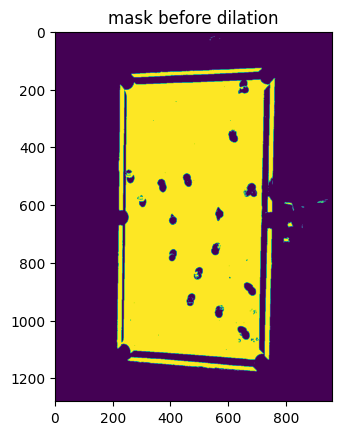

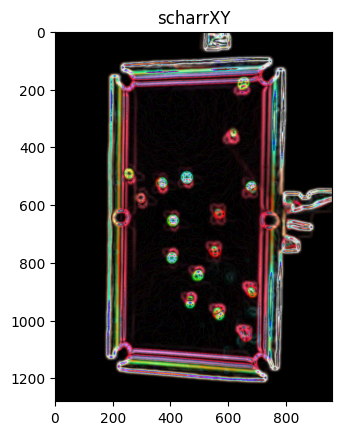

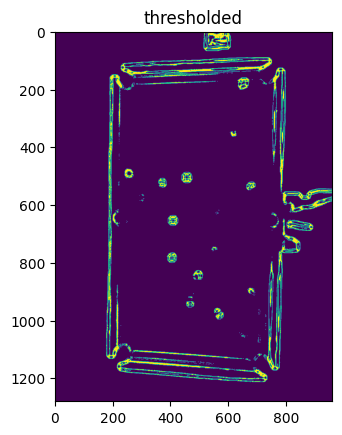

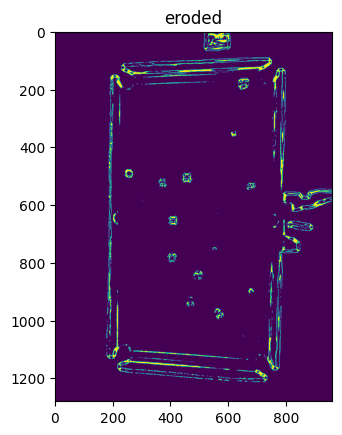

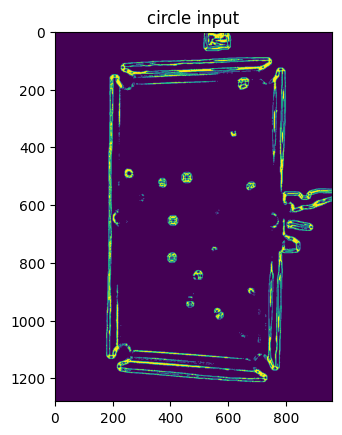

no circles found


In [203]:
input_dir = './new_images/1280x1280'
output_dir = './new_output_images'
for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.startswith('.'): continue
        if not file.startswith('IMG_2735'): continue
        image_path = os.path.join(root, file)
        color = cv2.imread(image_path,1)
        
        # if DEBUG == "ALL":
        #     plt.imshow(cv2.cvtColor(color, cv2.COLOR_BGR2RGB))
        #     plt.show()
        masked_img = mask_table(color)
        top_left = ()
        top_right = ()
        bottom_left = ()
        bottom_right = ()
        
        cont = contours(masked_img)
        # use hsv
        # apply after homography
        
        # kernel = np.ones((3, 3),np.uint8)
        # cont = cv2.dilate(cont, kernel)
        # cont = cv2.cvtColor(cont, cv2.COLOR_GRAY2BGR)
        circle_file = os.path.join('.', output_dir, 'circles', file)
        # label_file = os.path.join('.', output_dir, 'labels', file)
        circles = hough_circles(color, cont, circle_file)
        # balls = label_balls(color, circles, label_file)
